In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# load entity2id
entity2id = {}
with open("data/Freebase/FB15k/entity2id.txt", 'r', encoding='utf-8') as f:
    lines = f.readlines()
for line in lines:
    e, idx = line.strip().split('\t')
    entity2id[e] = int(idx)

In [3]:
# load relation2id
relation2id = {}
with open("data/Freebase/FB15k/relation2id.txt", 'r', encoding='utf-8') as f:
    lines = f.readlines()
for line in lines:
    r, idx = line.strip().split('\t')
    relation2id[r] = int(idx)

In [4]:
# load type2id
type2id = {}
with open("data/Freebase/FB15kET/type2id.txt", 'r', encoding='utf-8') as f:
    lines = f.readlines()
for line in lines:
    t, idx = line.strip().split('\t')
    type2id[t] = int(idx)

In [5]:
# load test set of FB15kET-I
test_e2t = {}
pair_test =0
with open("data/Freebase/FB15kET/FB15k_Entity_Type_test_clean.txt", 'r') as f:
    for line in f.readlines():
        pair_test+=1
        h, t = line.strip().split("\t")
        if entity2id[h] not in test_e2t:
            test_e2t[entity2id[h]] = []
        test_e2t[entity2id[h]].append(type2id[t])

In [6]:
# load validation set of FB15kET-I
dev_e2t = {}
with open("data/Freebase/FB15kET/FB15k_Entity_Type_valid_clean.txt", 'r') as f:
    for line in f.readlines():
        h, t = line.strip().split("\t")
        if entity2id[h] in test_e2t:                 # move ETIs whose entity exist in test set
            test_e2t[entity2id[h]].append(type2id[t])
        else:
            if entity2id[h] not in dev_e2t:
                dev_e2t[entity2id[h]] = []
            if type2id[t] not in dev_e2t[entity2id[h]]:
                dev_e2t[entity2id[h]].append(type2id[t])

In [7]:
# load validation set of FB15kET-I
train_e2t = {}
with open("data/Freebase/FB15kET/FB15k_Entity_Type_train.txt", 'r') as f:
    for line in f.readlines():
        h, t = line.strip().split("\t")
        if entity2id[h] in test_e2t:            # move ETIs whose entity exist in test set
            test_e2t[entity2id[h]].append(type2id[t])
        elif entity2id[h] in dev_e2t:           # move ETIs whose entity exist in validation set
            dev_e2t[entity2id[h]].append(type2id[t])
        else:
            if entity2id[h] not in train_e2t:
                train_e2t[entity2id[h]] = []
            if type2id[t] not in train_e2t[entity2id[h]]:
                train_e2t[entity2id[h]].append(type2id[t])

In [8]:
# load training set of FB15k
train_triplet = []
with open('data/Freebase/FB15k/freebase_mtr100_mte100-train.txt', 'r') as f:
    for line in f.readlines():
        h, l, t = line.strip().split("\t")
        train_triplet.append((entity2id[h],relation2id[l],entity2id[t]))

In [9]:
# extract triples from FB15k
entity_degree = np.zeros(len(entity2id))    #for filting entities
prior_num = 0
expansion_num = 0
evaluation_num = 0
prior_triple =[]
expansion_triple = {}
evaluation_triple = {}
for triple in train_triplet:
    h, r, t = triple
    if h in train_e2t or t in train_e2t:
        entity_degree[h] += 1
        entity_degree[t] += 1
        
        if h in train_e2t and t in train_e2t:
            prior_triple.append(triple)
            prior_num+=1
    
        if h in train_e2t and t in dev_e2t:
            if t not in expansion_triple:
                expansion_triple[t] = []
            expansion_triple[t].append(triple)
            expansion_num += 1
        if t in train_e2t and h in dev_e2t:
            if h not in expansion_triple:
                expansion_triple[h] = []
            expansion_num += 1
            expansion_triple[h].append(triple)


        if h in train_e2t and t in test_e2t:
            if t not in evaluation_triple:
                evaluation_triple[t] = []
            evaluation_num += 1
            evaluation_triple[t].append(triple)
        if t in train_e2t and h in test_e2t:
            if h not in evaluation_triple:
                evaluation_triple[h] = []
            evaluation_num += 1
            evaluation_triple[h].append(triple)
print("prior:",prior_num,"expansion:",expansion_num,"evaluation:",evaluation_num)

prior: 23440 expansion: 37070 evaluation: 136839


In [10]:
# filt entities will not connect with prior
for entity in entity2id:
    entity_ = entity2id[entity]
    if entity_degree[entity_]==0:
        if entity_ in dev_e2t:
            dev_e2t.pop(entity_)
        if entity_ in test_e2t:
            test_e2t.pop(entity_)

In [11]:
print("num of entities of FB15kET-I prior set: ", len(train_e2t))
print("num of entities of FB15kET-I expansion set: ",len(dev_e2t))
print("num of entities of FB15kET-I evaluation set: ",len(test_e2t))

num of entities of FB15kET-I prior set:  3436
num of entities of FB15kET-I expansion set:  2514
num of entities of FB15kET-I evaluation set:  7983


In [12]:
ETIs_num =0
for entity_ in train_e2t:
    ETIs_num += len(train_e2t[entity_])
print("num of pairs of FB15kET-I prior set: ", ETIs_num)
    
ETIs_num =0
for entity_ in dev_e2t:
    ETIs_num += len(dev_e2t[entity_])
print("num of pairs of FB15kET-I expansion set: ", ETIs_num)
    
ETIs_num =0
for entity_ in test_e2t:
    ETIs_num += len(test_e2t[entity_])
print("num of pairs of FB15kET-I evaluation set: ", ETIs_num)

num of pairs of FB15kET-I prior set:  17829
num of pairs of FB15kET-I expansion set:  24356
num of pairs of FB15kET-I evaluation set:  118231


In [13]:
p_h = {}
p_t = {}

for triple in prior_triple:
    h, r, t = triple
    for type_h in train_e2t[h]:
        for type_t in train_e2t[t]:
            if (type_h, r) not in p_h:
                p_h[(type_h, r)] = {}
            if type_t not in p_h[(type_h, r)]:
                p_h[(type_h, r)][type_t] = 1
            else:
                p_h[(type_h, r)][type_t] += 1

            if (r, type_t) not in p_t:
                p_t[(r, type_t)] = {}
            if type_h not in p_t[(r, type_t)]:
                p_t[(r, type_t)][type_h] = 1
            else:
                p_t[(r, type_t)][type_h] += 1

In [14]:
h_count = {}
t_count = {}
for h_r in p_h:
    type_h, r = h_r
    count = sum(list(p_h[h_r].values()))
    h_count[h_r] = count
    p_h[h_r] = pd.DataFrame(list(p_h[h_r].values()),index=p_h[h_r].keys())

for r_t in p_t:
    r, type_t = r_t
    count = sum(list(p_t[r_t].values()))
    t_count[r_t] = count
    p_t[r_t] = pd.DataFrame(list(p_t[r_t].values()),index=p_t[r_t].keys())

In [15]:
def evaluation(entity2type):
    mr = mrr = hit10 = hit3 =hit1 = 0
    fmr = fmrr = fhit10 = fhit3 = fhit1 = 0
    for entity_ in test_e2t:
        type_arg = np.argsort(-entity2type[entity_])
        test_rank_list = []
        train_rank_list = []
        valid_rank_list = []
        if entity_ in test_e2t:
            for type_label in test_e2t[entity_]:
                rank = (type_arg==type_label).nonzero()[0].item()+1
                test_rank_list.append(rank)
        if entity_ in dev_e2t:
            for type_label in dev_e2t[entity_]:
                rank = (type_arg==type_label).nonzero()[0].item()+1
                valid_rank_list.append(rank)
        if entity_ in train_e2t:
            for type_label in train_e2t[entity_]:
                rank = (type_arg==type_label).nonzero()[0].item()+1
                train_rank_list.append(rank)
        rank_list = train_rank_list + test_rank_list + valid_rank_list
        rank_list.sort()
        
        for i, rank in enumerate(test_rank_list):
            #rank is ’raw‘ rank
            #raw-index is the rank of all correct
            #rank - raw_index is filt rank
            raw_index = rank_list.index(rank)
            frank = rank - raw_index

            #if rank == raw_index  frank shoud be 1
            if frank == 0:
                frank = 1

            fmr += frank
            fmrr += 1.0/frank
            if frank <=10:
                fhit10 += 1
            if frank <=3:
                fhit3 += 1
            if frank <= 1:
                fhit1 += 1
    
    num_of_e2t = 0
    for i in test_e2t:
        num_of_e2t += len(test_e2t[i])
        
    return fmrr/num_of_e2t, fhit1/num_of_e2t, fhit3/num_of_e2t, fhit10/num_of_e2t

In [16]:
def aggrate_and_evaluation():
    entity2type = np.zeros((len(entity2id), len(type2id)))
    for i, triplet in enumerate(train_triplet):
        h, r, t = triplet
        
        if h in train_e2t:
            normalize_h = len(train_e2t[h])
            for type_h in train_e2t[h]:
                if (type_h, r) in p_h:
                    df = p_h[(type_h, r)]
                    t_key = list(df.index)
                    t_value = df.values.reshape(-1)
                    entity2type[t][t_key] += t_value/h_count[(type_h, r)]/normalize_h

        if t in train_e2t:
            normalize_t = len(train_e2t[t])
            for type_t in train_e2t[t]:
                if (r, type_t) in p_t:
                    df = p_t[(r, type_t)]
                    h_key = list(df.index)
                    h_value = df.values.reshape(-1)
                    entity2type[h][h_key] += h_value/t_count[(r, type_t)]/normalize_t
    test_evaluation = evaluation(entity2type)
    return test_evaluation

In [17]:
test_reslut = []
add_num =0 
test_evaluation = aggrate_and_evaluation()
test_reslut.append(test_evaluation)
print("add",str(add_num)+" entities, results：", test_evaluation)
# add entities in turn
for add_entity in dev_e2t:
    add_num += 1
    for triplet in expansion_triple[add_entity]:
        h, r, t = triplet
        if h == add_entity:
            for type_h in dev_e2t[h]:
                for type_t in train_e2t[t]:
                    if (type_h, r) not in p_h:
                        p_h[(type_h, r)] = pd.DataFrame([1],index =[type_t])
                    else:
                        if type_t not in p_h[(type_h, r)].index:
                            p_h[(type_h, r)].loc[type_t] = 1
                        else:
                            p_h[(type_h, r)].loc[type_t] += 1
                            
                    if (r, type_t) not in p_t:
                        p_t[(r, type_t)] = pd.DataFrame([1],index =[type_h])
                    else:
                        if type_h not in p_t[(r, type_t)].index:
                            p_t[(r, type_t)].loc[type_h] = 1
                        else:
                            p_t[(r, type_t)].loc[type_h] += 1
        if t == add_entity:
            for type_h in train_e2t[h]:
                for type_t in dev_e2t[t]:
                    if (type_h, r) not in p_h:
                        p_h[(type_h, r)] = pd.DataFrame([1],index =[type_t])
                    else:
                        if type_t not in p_h[(type_h, r)].index:
                            p_h[(type_h, r)].loc[type_t] = 1
                        else:
                            p_h[(type_h, r)].loc[type_t] += 1
                            
                    if (r, type_t) not in p_t:
                        p_t[(r, type_t)] = pd.DataFrame([1],index =[type_h])
                    else:
                        if type_h not in p_t[(r, type_t)].index:
                            p_t[(r, type_t)].loc[type_h] = 1
                        else:
                            p_t[(r, type_t)].loc[type_h] += 1
            
            
                        
    for h_r in p_h:
        count = sum(p_h[h_r].values).item()
        h_count[h_r] = count
        
    for r_t in p_t:
        count = sum(p_t[r_t].values).item()
        t_count[r_t] = count
        
        
    if add_num % 100 == 0:
        test_evaluation = aggrate_and_evaluation()
        test_reslut.append(test_evaluation)
        print("add",str(add_num)+" entities, results：", test_evaluation)

add 0 entities, results： (0.44649724283600656, 0.3620793192986611, 0.48155729038915346, 0.6195075741556783)
add 100 entities, results： (0.45540602751832515, 0.3696577039862642, 0.49237509620996184, 0.6299786012128799)
add 200 entities, results： (0.45621864235418863, 0.36931092522265735, 0.49459955510822035, 0.6322960983160085)
add 300 entities, results： (0.46037918973505293, 0.37275333880285205, 0.4987355262156287, 0.6388848948245384)
add 400 entities, results： (0.4632529709246968, 0.37520616420397357, 0.5017042907528483, 0.6434691409190483)
add 500 entities, results： (0.46451955595847844, 0.37580668352631713, 0.5039118336138576, 0.6471483790207306)
add 600 entities, results： (0.46795129307987593, 0.3793675093672556, 0.505967132139625, 0.6509037392900339)
add 700 entities, results： (0.46996174157507886, 0.3812198154460336, 0.5072442929519331, 0.6538978778831271)
add 800 entities, results： (0.47106968229114804, 0.3824800602210926, 0.5080562627398906, 0.6551242905836878)
add 900 entities

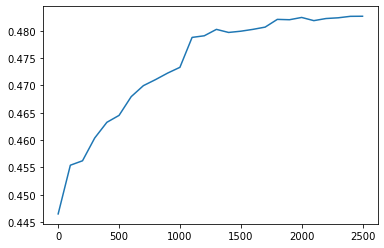

In [18]:
result_array = np.array(test_reslut)
# np.savetxt('add_val.csv',result_array,delimiter=',')
plt.plot([100*i for i in range(0,26)],result_array[:,0])     # plot mrr

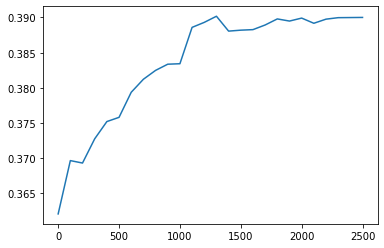

In [19]:
plt.plot([100*i for i in range(0,26)],result_array[:,1])     # plot h@1

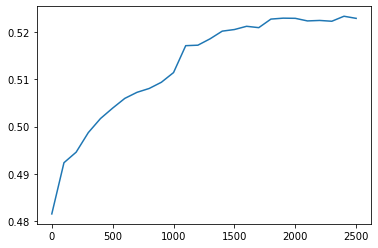

In [20]:
plt.plot([100*i for i in range(0,26)],result_array[:,2])     # plot h@3

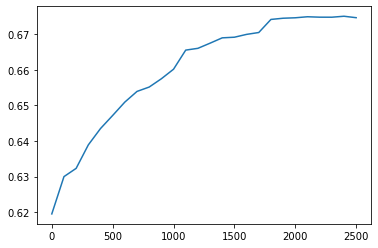

In [21]:
plt.plot([100*i for i in range(0,26)],result_array[:,3])     # plot h@10